In [80]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [81]:
d = 16  # Embedding dimension
seq_len = 5  # Sequence length

In [82]:
# Compute inverse frequencies theta_k for each pair of dimensions
k = np.arange(d // 2)  # 0, 1, 2, ..., d/2 - 1
print(f"{k=}")
print(f"{k.shape=}")

exponent = 2 * k / d  # ranges from 0 to 1 with d // 2 elements, one for each pair of dimensions
print(f"{exponent=}")
print(f"{exponent.shape=}")

theta = 10000 ** exponent  # Spreads out frequencies between 0 and 10000
print(f"{[float(x) for x in np.round(theta, 2)]}")
print(f"{theta.shape=}")


k=array([0, 1, 2, 3, 4, 5, 6, 7])
k.shape=(8,)
exponent=array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875])
exponent.shape=(8,)
[1.0, 3.16, 10.0, 31.62, 100.0, 316.23, 1000.0, 3162.28]
theta.shape=(8,)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.32, 0.1, 0.03, 0.01, 0.0, 0.0, 0.0]
[2.0, 0.63, 0.2, 0.06, 0.02, 0.01, 0.0, 0.0]
[3.0, 0.95, 0.3, 0.09, 0.03, 0.01, 0.0, 0.0]
[4.0, 1.26, 0.4, 0.13, 0.04, 0.01, 0.0, 0.0]
Angle shape: (5, 8)


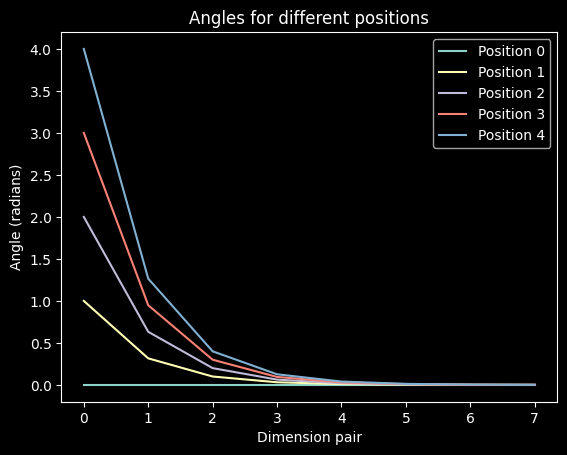

In [83]:
# For each position in the sequence, calculate the rotation angles angle_{pos, k}.
pos = np.arange(seq_len)[:, np.newaxis]  # 0, 1, 2, ..., seq_len - 1

# Shape of theta is (d,), pos is (seq_len, 1)
# Implicitly broadcast pos to (seq_len, d) by repeating the columns
# theta is implicitly treated as (1, d) and broadcast to (seq_len, d) by repeating the single row
angle = pos / theta  # shape is (seq_len, d) - for each position we get d angles

for row in angle:
    print(f"{[float(x) for x in np.round(row, 2)]}")
    
print(f"Angle shape: {angle.shape}")

for i in range(seq_len):
    plt.plot(angle[i], label=f"Position {i}")
plt.legend()
plt.xlabel("Dimension pair")
plt.ylabel("Angle (radians)")
plt.title("Angles for different positions")
plt.show()


Positional Dependency: Each position in the sequence has its own set of rotation angles, one for each pair of dimensions.

Frequency Scaling: The **inverse** frequency theta_k increases exponentially with k, meaning higher pairs of dimensions have smaller rotation angles for the same position.

Rotation Matrices: These angles are used to construct rotation matrices that rotate the token embeddings based on their positions.

Implications:
Longer-Range Dependencies: Lower pairs of dimensions (smaller k) have larger rotation angles, capturing longer-range dependencies.

Shorter-Range Dependencies: Higher pairs of dimensions (larger k) have smaller rotation angles, capturing finer details and shorter-range dependencies.


where \($\theta$\) is the rotation angle.

The Rotation Matrix used in Rotary Positional Encoding are multiple blocks of the 2-D rotation matrix. The rotation matrix for the k-th pair of dimensions is given as

\begin{bmatrix}
\cos(\theta_k) & -\sin(\theta_k) \\
\sin(\theta_k) & \cos(\theta_k)
\end{bmatrix}


where \($\theta_k = \frac{1}{2^{k/d}}$\)

where d is the dimension of the input embeddings.


We have d//2 angles because we're rotating pairs of dimensions. For each position (seq_len), we need d//2 different rotation angles, the rotation matrix R is (seq_len, d, d) because:

For each position (seq_len) we need a full d×d matrix that can transform a d-dimensional vector. The matrix looks like this for d=4:
```python
R[0] = [
    [cos[0,0], -sin[0,0],    0    ,    0     ],  # First pair rotation
    [sin[0,0],  cos[0,0],    0    ,    0     ],
    [   0    ,    0     , cos[0,1], -sin[0,1]],  # Second pair rotation
    [   0    ,    0     , sin[0,1],  cos[0,1]]
]
```

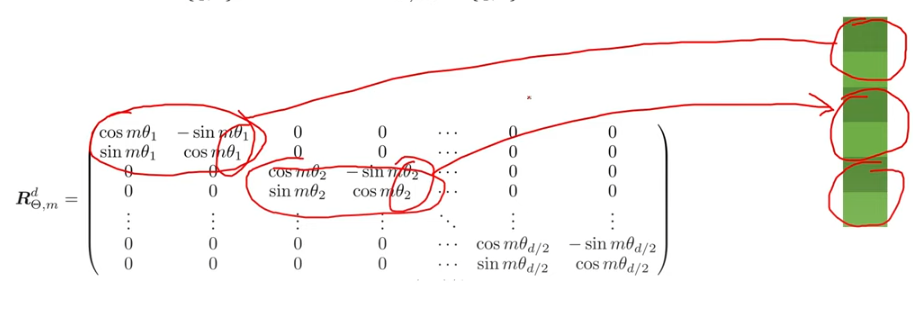

In [84]:
# Create rotation matrices R_pos using sine and cosine of the angles.
cos = np.cos(angle)  # shape is (seq_len, d)
sin = np.sin(angle)  # shape is (seq_len, d)

R = np.zeros((seq_len, d, d))

for i in range(seq_len):  # Iterate over positions
    pos_rot_mat = R[i]  # Extract rotation matrix for this position, (d, d)
    for j in range(d // 2):  # Iterate over all pairs of dimensions
        # Extract indices for current rotation matrix
        even = 2 * j
        odd = even + 1

        # Fill out diagonal (cos)
        pos_rot_mat[even, even] = cos[i, j]
        pos_rot_mat[odd, odd] = cos[i, j]

        # Fill out off-diagonal (sin)
        pos_rot_mat[even, odd] = -sin[i, j]
        pos_rot_mat[odd, even] = sin[i, j]


print(f"Rotation matrix shape: {R.shape}")
print(f"{R[3][8]=}")


Rotation matrix shape: (5, 16, 16)
R[3][8]=array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.99955003, -0.0299955 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])


In [85]:
# Create random token embeddings for demonstration.
np.random.seed(42)
E = np.random.randn(seq_len, d)

In [86]:
# Multiply each token embedding by its corresponding rotation matrix.
E_expanded = E[:, :, np.newaxis]  # shape is (seq_len, d, 1)
E_rotated = R @ E_expanded  # shape is (seq_len, d, d) @ (seq_len, d, 1) = (seq_len, d, 1)
E_rotated = E_rotated.squeeze()  # shape is (seq_len, d)

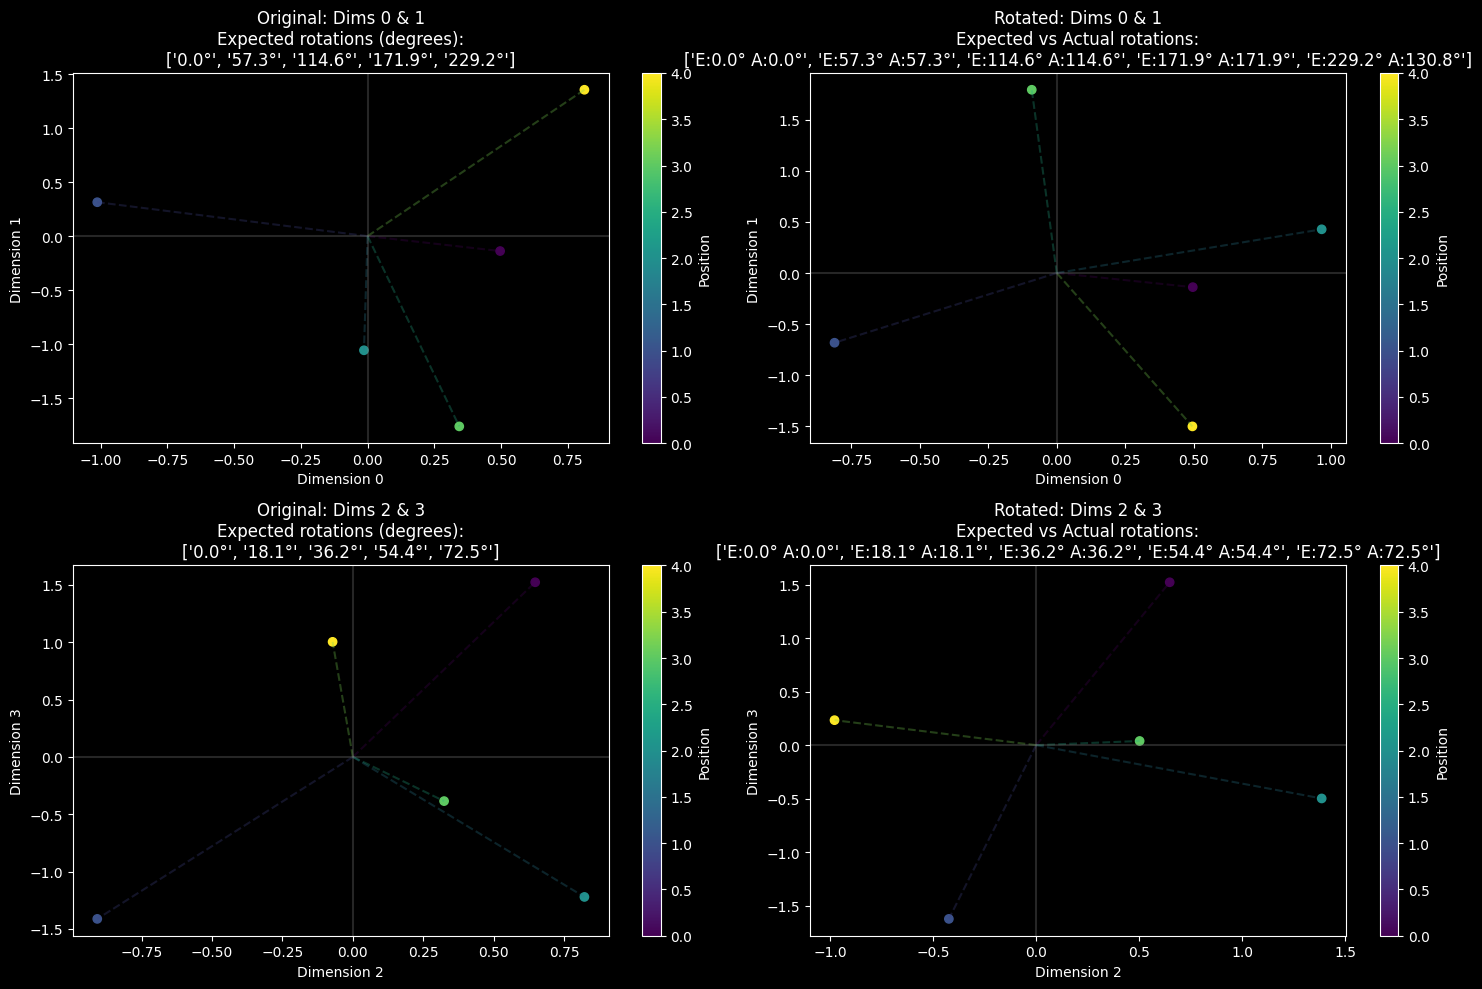

In [87]:
# Plot the original and rotated embeddings with angle information
num_dim_pairs_to_plot = 2  # This will plot pairs (0,1) and (2,3)
n_pairs = num_dim_pairs_to_plot

# Function to calculate angle between vectors in degrees
def calc_angle_between_vectors(v1, v2):
    # Get angle using dot product formula: cos(θ) = (v1 · v2) / (|v1| |v2|)
    dot_product = np.dot(v1, v2)
    norms = np.linalg.norm(v1) * np.linalg.norm(v2)
    cos_angle = dot_product / norms
    # Handle numerical instability
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_rad = np.arccos(cos_angle)
    return np.degrees(angle_rad)

plt.figure(figsize=(15, 5 * n_pairs))

for pair_idx in range(n_pairs):
    # Get the dimensions for this pair
    dim1 = 2 * pair_idx
    dim2 = 2 * pair_idx + 1
    
    # Get expected rotation angles for this pair in degrees
    expected_angles_deg = np.degrees(angle[:, pair_idx])
    
    # Calculate actual rotation angles
    actual_angles_deg = []
    for k in range(seq_len):
        original_vec = E[k, [dim1, dim2]]
        rotated_vec = E_rotated[k, [dim1, dim2]]
        actual_angle = calc_angle_between_vectors(original_vec, rotated_vec)
        actual_angles_deg.append(actual_angle)
    
    # Original embeddings with angle visualization
    plt.subplot(n_pairs, 2, 2*pair_idx + 1)
    scatter = plt.scatter(E[:, dim1], E[:, dim2], c=pos, cmap='viridis')
    
    # Draw lines from origin to points to visualize angles
    for k in range(seq_len):
        x, y = E[k, dim1], E[k, dim2]
        plt.plot([0, x], [0, y], '--', alpha=0.3, 
                color=plt.cm.viridis(k/seq_len))
        
    plt.title(f'Original: Dims {dim1} & {dim2}\n'
             f'Expected rotations (degrees):\n'
             f'{[f"{a:.1f}°" for a in expected_angles_deg]}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    plt.colorbar(scatter, label='Position')
    
    # Rotated embeddings with angle visualization
    plt.subplot(n_pairs, 2, 2*pair_idx + 2)
    scatter = plt.scatter(E_rotated[:, dim1], E_rotated[:, dim2], 
                        c=pos, cmap='viridis')
    
    # Draw lines from origin to points to visualize angles
    for k in range(seq_len):
        x, y = E_rotated[k, dim1], E_rotated[k, dim2]
        plt.plot([0, x], [0, y], '--', alpha=0.3, 
                color=plt.cm.viridis(k/seq_len))
        
    plt.title(f'Rotated: Dims {dim1} & {dim2}\n'
             f'Expected vs Actual rotations:\n'
             f'{[f"E:{e:.1f}° A:{a:.1f}°" for e, a in zip(expected_angles_deg, actual_angles_deg)]}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    plt.colorbar(scatter, label='Position')

plt.tight_layout()
plt.show()

In [106]:
import torch
import torch.nn as nn
import math

class RoPEAttention(nn.Module):
    def __init__(self, d_model: int = 256, num_heads: int = 8, max_seq_length: int = 512):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.max_seq_length = max_seq_length
        
        # Create Q, K, V projections
        self.qkv_proj = nn.Linear(d_model, d_model * 3)  # Combined projection
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Precompute rotation matrices
        self.register_buffer("rope_cache", self._create_rope_cache())
    
    def _create_rope_cache(self):
        # Create position-dependent rotation matrices
        positions = torch.arange(self.max_seq_length)
        dims = torch.arange(self.head_dim // 2)
        
        # Compute theta
        theta = 10000 ** (-2 * dims / self.head_dim)
        
        # Compute angles for each position and dimension pair
        angles = positions[:, None] * theta[None, :]  # (seq_len, head_dim//2)
        
        # Cache sin and cos values
        cache = torch.stack([torch.cos(angles), torch.sin(angles)], dim=-1)
        return cache  # shape: (seq_len, head_dim//2, 2)

    def apply_rotary_embeddings(self, x: torch.Tensor, start_position: int = 0) -> torch.Tensor:
        """Apply rotary embeddings to input tensor x."""
        seq_len = x.shape[1]

        # Extract the relevant position-dependent rotation matrices
        rope_cache = self.rope_cache[start_position:start_position + seq_len]
        
        # Reshape x to separate out pairs of dimensions
        x_reshape = x.view(*x.shape[:-1], -1, 2)
        
        # Get cos and sin from cache
        cos = rope_cache[..., 0].unsqueeze(-2)  # Shape is (seq_len, 1, 1, head_dim//2)
        sin = rope_cache[..., 1].unsqueeze(-2)  # Shape is (seq_len, 1, 1, head_dim//2)

        print(f"{cos.shape=}")
        print(f"{sin.shape=}")

        # TODO: Break out the shapes here in a better way
        
        # Apply rotation using the formula:
        # [cos(θ) -sin(θ)] [x_even]
        # [sin(θ)  cos(θ)] [x_odd ]
        x_out = torch.stack([
            x_reshape[..., 0] * cos - x_reshape[..., 1] * sin,
            x_reshape[..., 0] * sin + x_reshape[..., 1] * cos
        ], dim=-1)
        
        return x_out.flatten(-2)  # Recombine pairs of dimensions

    def forward(self, x: torch.Tensor, start_position: int = 0) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        # Combined Q, K, V projection
        qkv = self.qkv_proj(x)  # [batch_size, seq_len, 3 * d_model]
        q, k, v = qkv.chunk(3, dim=-1)  # Each is [batch_size, seq_len, d_model]
        
        # Reshape to multiple heads
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Shape is now [batch_size, num_heads, seq_len, head_dim]
        
        # Apply RoPE to Q and K
        q = self.apply_rotary_embeddings(q, start_position)
        k = self.apply_rotary_embeddings(k, start_position)
        
        # Compute attention scores
        scale = 1.0 / math.sqrt(self.head_dim)
        scores = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = torch.softmax(scores, dim=-1)
        
        # Apply attention to V
        out = torch.matmul(attn, v)  # [batch_size, num_heads, seq_len, head_dim]
        
        # Combine heads and project
        out = out.transpose(1, 2).contiguous()  # [batch_size, seq_len, num_heads, head_dim]
        out = out.view(batch_size, seq_len, self.d_model)
        out = self.out_proj(out)
        
        return out




In [107]:

model = RoPEAttention(d_model=256, num_heads=8, max_seq_length=1024)

# Simulate a conversation happening over time
messages = [
    "Hello, how are",  # First part
    " you today?",     # Second part
    " I'm doing great!"# Third part
]

# Process each message as it arrives
current_position = 0
for i, msg in enumerate(messages):
    print(f"\nProcessing message part {i+1}: '{msg}'")
    print(f"Current position before processing: {current_position}")
    
    # Simulate tokenization
    num_tokens = len(msg.split())
    x = torch.randn(1, num_tokens, 256)  # Simulated token embeddings
    
    # Process the new tokens
    output = model(x, start_position=current_position)
    current_position += num_tokens
    
    print(f"Output shape: {output.shape}")
    print(f"New position after processing: {current_position}")


Processing message part 1: 'Hello, how are'
Current position before processing: 0
cos.shape=torch.Size([8, 1, 16])
sin.shape=torch.Size([8, 1, 16])
cos.shape=torch.Size([8, 1, 16])
sin.shape=torch.Size([8, 1, 16])
Output shape: torch.Size([1, 3, 256])
New position after processing: 3

Processing message part 2: ' you today?'
Current position before processing: 3
cos.shape=torch.Size([8, 1, 16])
sin.shape=torch.Size([8, 1, 16])
cos.shape=torch.Size([8, 1, 16])
sin.shape=torch.Size([8, 1, 16])
Output shape: torch.Size([1, 2, 256])
New position after processing: 5

Processing message part 3: ' I'm doing great!'
Current position before processing: 5
cos.shape=torch.Size([8, 1, 16])
sin.shape=torch.Size([8, 1, 16])
cos.shape=torch.Size([8, 1, 16])
sin.shape=torch.Size([8, 1, 16])
Output shape: torch.Size([1, 3, 256])
New position after processing: 8
